### Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from TST import build_tst_model

### Load Data

In [3]:
df = pd.read_csv('power_system_load_dataset.csv')
df.head()

,datetime,load_demand_MW,temperature_C,humidity_%,solar_irradiation_Wm2,population,gni_per_capita_usd,power_price_usd_per_kwh,day_of_week,hour_of_day,is_holiday,season,year,month,week_of_year,lag_1_hour_load,lag_1_day_load,moving_avg_7_day
0,1/2/2022 00:00,345.002816,9.427559,68.088984,0.000000,99936.63089,11953.27443,0.102040,6,0,1,Winter,2022,1,52,311.964886,325.355743,281.228513
1,1/2/2022 01:00,328.187143,10.738169,69.813695,4.454484,99915.28834,12416.27607,0.103144,6,1,1,Winter,2022,1,52,345.002816,311.990460,283.034614
2,1/2/2022 02:00,336.269392,8.214337,76.005330,8.605403,99963.95966,12023.44142,0.110978,6,2,1,Winter,2022,1,52,328.187143,335.310725,285.006272
3,1/2/2022 03:00,305.035233,11.267720,76.486239,12.169878,100053.59350,11978.03532,0.104880,6,3,1,Winter,2022,1,52,336.269392,327.400532,285.721592
4,1/2/2022 04:00,299.085592,9.315047,85.635396,14.904995,100633.82520,11921.46673,0.116045,6,4,1,Winter,2022,1,52,305.035233,295.037854,286.182420


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
df.set_index(['datetime'], inplace=True)

In [6]:
# Find missing timestamps
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
print(f'Missing timestamps : \n{full_range.difference(df.index)}')


Missing timestamps : 
DatetimeIndex([], dtype='datetime64[ns]', freq='h')


In [7]:
df.index.freq = 'h'
df.index

DatetimeIndex(['2022-01-02 00:00:00', '2022-01-02 01:00:00',
               '2022-01-02 02:00:00', '2022-01-02 03:00:00',
               '2022-01-02 04:00:00', '2022-01-02 05:00:00',
               '2022-01-02 06:00:00', '2022-01-02 07:00:00',
               '2022-01-02 08:00:00', '2022-01-02 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=17496, freq='h')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17496 entries, 2022-01-02 00:00:00 to 2023-12-31 23:00:00
Freq: h
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   load_demand_MW           17496 non-null  float64
 1   temperature_C            17496 non-null  float64
 2   humidity_%               17496 non-null  float64
 3   solar_irradiation_Wm2    17496 non-null  float64
 4   population               17496 non-null  float64
 5   gni_per_capita_usd       17496 non-null  float64
 6   power_price_usd_per_kwh  17496 non-null  float64
 7   day_of_week              17496 non-null  int64  
 8   hour_of_day              17496 non-null  int64  
 9   is_holiday               17496 non-null  int64  
 10  season                   17496 non-null  object 
 11  year                     17496 non-null  int64  
 12  month                    17496 non-null  int64  
 13  week_of_year             17496 no

In [9]:
df.season = df.season.astype('category')
df.season.unique()

['Winter', 'Spring', 'Summer', 'Autumn']
Categories (4, object): ['Autumn', 'Spring', 'Summer', 'Winter']

In [10]:
df.isnull().sum()

load_demand_MW             0
temperature_C              0
humidity_%                 0
solar_irradiation_Wm2      0
population                 0
gni_per_capita_usd         0
power_price_usd_per_kwh    0
day_of_week                0
hour_of_day                0
is_holiday                 0
season                     0
year                       0
month                      0
week_of_year               0
lag_1_hour_load            0
lag_1_day_load             0
moving_avg_7_day           0
dtype: int64

In [11]:
df.describe().load_demand_MW

count    17496.000000
mean       289.910707
std         40.989025
min        175.598255
25%        257.094659
50%        289.826316
75%        322.538982
max        418.822736
Name: load_demand_MW, dtype: float64

### Data Visualization

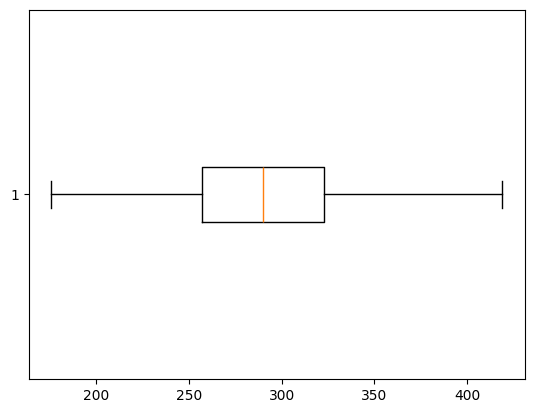

In [12]:
plt.boxplot(df.load_demand_MW, vert=False)
plt.show()

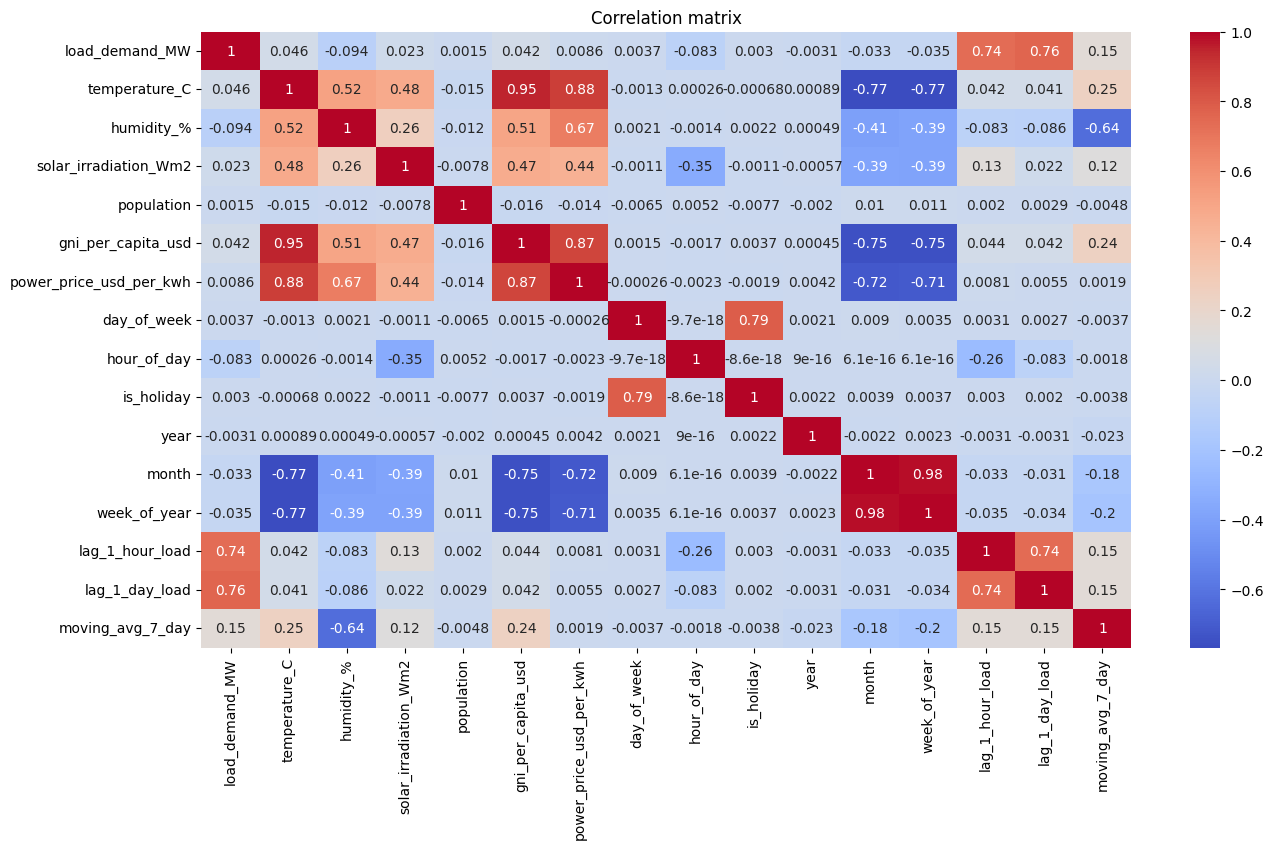

In [13]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

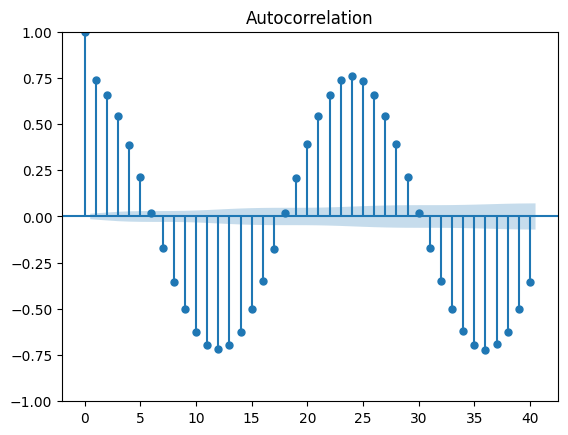

In [14]:
plot_acf(df.load_demand_MW, lags=40)
plt.show()

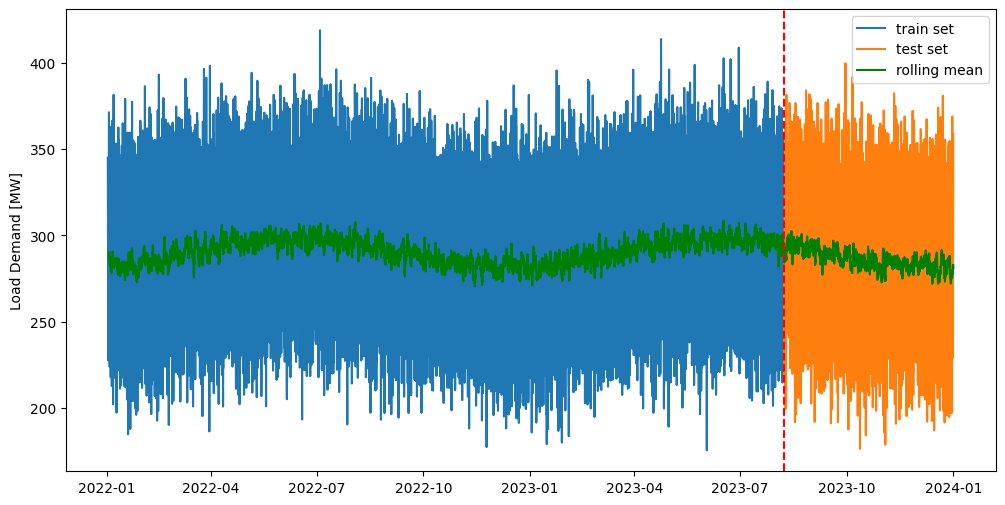

In [15]:
train_size = int(len(df) * 0.8)
train_df = df[['load_demand_MW']].iloc[:train_size]
test_df = df[['load_demand_MW']].iloc[train_size:]
plt.figure(figsize=(12, 6))
plt.plot(train_df)
plt.plot(test_df)
plt.plot(df.load_demand_MW.rolling(window=24).mean(), color='green')
plt.axvline(train_df.index[-1], color='red', linestyle='--')
plt.ylabel('Load Demand [MW]')
plt.legend(['train set', 'test set', 'rolling mean'], loc='upper right')
plt.show()

### Data Preprocessing

In [16]:
def create_sequences(data, seq_length=4):
    """
    data: numpy array of scaled features
    seq_length: how many previous time steps to use
    
    Returns:
    X: sequences of features (samples, seq_length, features)
    y: target values at next time step (samples, 1)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length]) 
    return np.array(X), np.array(y)

In [17]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['load_demand_MW']])

In [18]:
X, y = create_sequences(data_scaled, seq_length=24)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13996, 24, 1)
(13996, 1)
(3476, 24, 1)
(3476, 1)


### TST model

In [39]:
model = build_tst_model(seq_len=24, feature_dim=1, num_heads=4, num_layers=4)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "model_TST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 24, 64)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_1           │ (None, 24, 64)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_4           │ (None, 24, 64)         │        83,200 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_5           │ (None, 24, 64)         │        83,200 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_6           │ (None, 24, 64)         │        83,200 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_7           │ (None, 24, 64)         │        83,200 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,993 (1.27 MB)

 Trainable params: 332,993 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
hist = model.fit(X_train, y_train, epochs=10, batch_size=64, shuffle=False, validation_split=0.1, verbose=2, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/10
197/197 - 12s - 59ms/step - loss: 0.1804 - mae: 0.2200 - mape: 39513.3203 - val_loss: 0.0281 - val_mae: 0.1422 - val_mape: 35.6056
Epoch 2/10
197/197 - 5s - 26ms/step - loss: 0.0301 - mae: 0.1460 - mape: 44926.4141 - val_loss: 0.0280 - val_mae: 0.1418 - val_mape: 35.4144
Epoch 3/10
197/197 - 5s - 26ms/step - loss: 0.0292 - mae: 0.1436 - mape: 34416.8242 - val_loss: 0.0197 - val_mae: 0.1160 - val_mape: 28.5557
Epoch 4/10
197/197 - 5s - 26ms/step - loss: 0.0101 - mae: 0.0800 - mape: 24766.0430 - val_loss: 0.0084 - val_mae: 0.0737 - val_mape: 16.7014
Epoch 5/10
197/197 - 5s - 26ms/step - loss: 0.0092 - mae: 0.0763 - mape: 29507.6523 - val_loss: 0.0087 - val_mae: 0.0747 - val_mape: 16.6917
Epoch 6/10
197/197 - 5s - 25ms/step - loss: 0.0091 - mae: 0.0760 - mape: 25021.0117 - val_loss: 0.0080 - val_mae: 0.0715 - val_mape: 16.3377
Epoch 7/10
197/197 - 5s - 26ms/step - loss: 0.0087 - mae: 0.0742 - mape: 19948.9180 - val_loss: 0.0086 - val_mae: 0.0744 - val_mape: 16.6308
Epoch 8/10
1

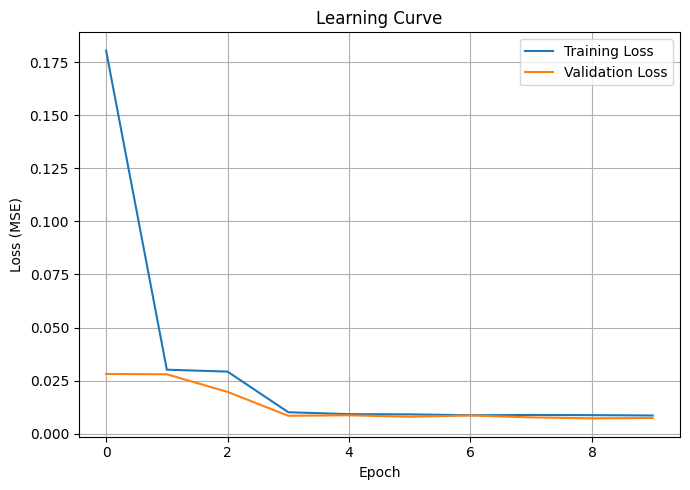

In [41]:
plt.figure(figsize=(7, 5))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
model.evaluate(X_test, y_test)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0082 - mae: 0.0722 - mape: 23.2920


[0.008872468024492264, 0.07525219768285751, 26.726318359375]

In [43]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


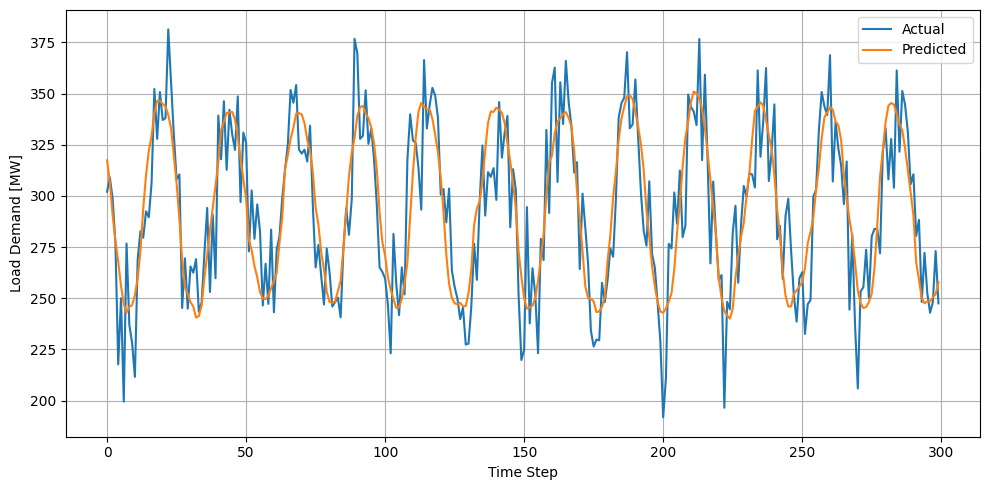

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:300], label='Actual')
plt.plot(y_pred_inv[:300], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Load Demand [MW]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
print(f'mae = {mae:.2f} MW \nmape = {mape:.2f} %')

mae = 18.30 MW 
mape = 6.72 %


### TST model (tsai)

In [1]:
from tsai.all import *

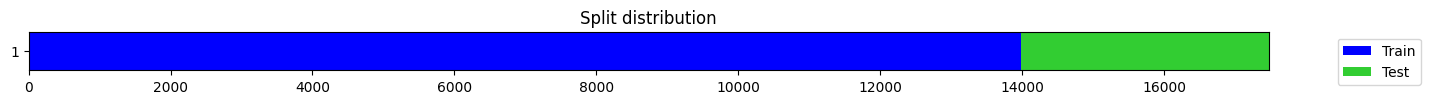

In [21]:
series = df['load_demand_MW'].values.astype(np.float32)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(series.reshape(-1, 1))
X, y = SlidingWindow(window_len=24, horizon=1, stride=1)(data_scaled)
splits = get_splits(o=y, valid_size=0.2, shuffle=False)

In [22]:
dls = get_ts_dls(X, y, splits=splits, y_block=RegressionBlock)

In [68]:
model = TST(
    c_in=dls.vars,
    c_out=1,
    seq_len=dls.len,
    d_model=64,
    n_heads=4,
    n_layers=4,
    d_ff=128,
    dropout=0.1,
    act='gelu',
    fc_dropout=0.1,
    y_range=None,
)

In [69]:
from fastai.callback.tracker import EarlyStoppingCallback
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])
learn.fit_one_cycle(30, 1e-3)

epoch,train_loss,valid_loss,_rmse,time
0,0.096338,0.113272,0.336559,00:05
1,0.039938,0.082036,0.286419,00:05
2,0.017503,0.074069,0.272157,00:04
3,0.011132,0.067102,0.259041,00:04
4,0.009934,0.050942,0.225704,00:04
5,0.009892,0.042152,0.205310,00:04
6,0.009561,0.022116,0.148715,00:05
7,0.009694,0.013513,0.116246,00:04
8,0.009222,0.020747,0.144040,00:04
9,0.008880,0.022582,0.150273,00:04


No improvement since epoch 12: early stopping


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

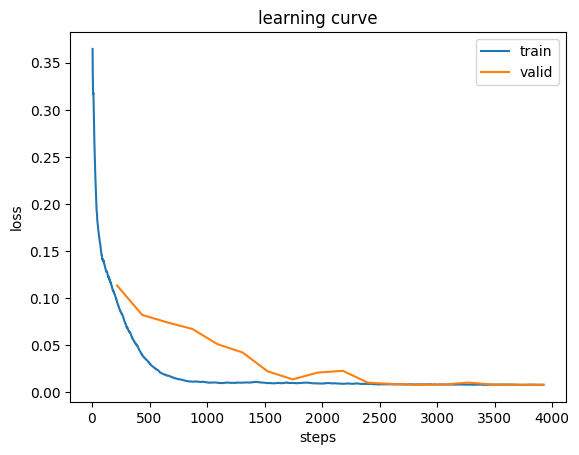

In [70]:
learn.recorder.plot_loss()

In [75]:
preds, targets = learn.get_preds()
# Invert scaling for comparison
preds_inv = scaler.inverse_transform(preds.numpy().reshape(-1, 1)).flatten()
targets_inv = scaler.inverse_transform(targets.numpy().reshape(-1, 1)).flatten()

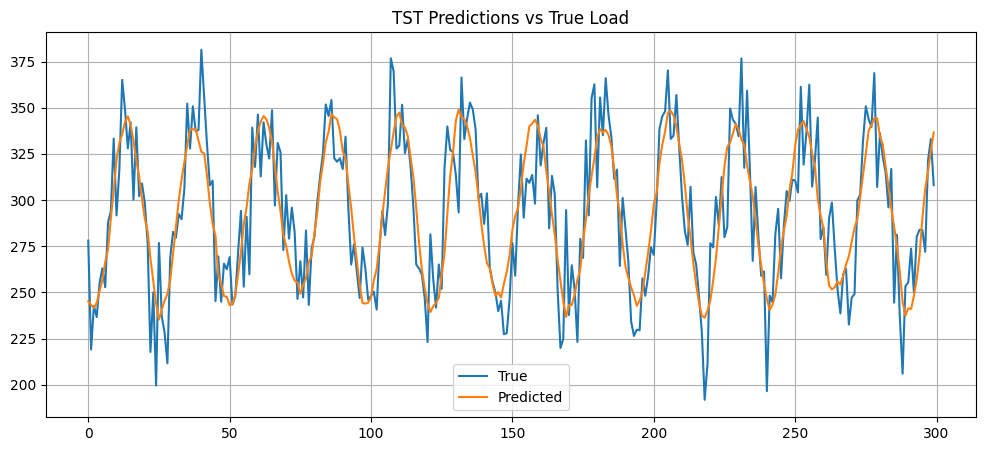

In [72]:
plt.figure(figsize=(12, 5))
plt.plot(targets_inv[:300], label='True')
plt.plot(preds_inv[:300], label='Predicted')
plt.title("TST Predictions vs True Load")
plt.legend()
plt.grid()
plt.show()


In [76]:
mae = mean_absolute_error(targets_inv, preds_inv)
mape = mean_absolute_percentage_error(targets_inv, preds_inv) * 100
print(f'mae = {mae:.2f} MW \nmape = {mape:.2f} %')

mae = 17.09 MW 
mape = 6.20 %
